In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_Rome_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_Rome_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_Rome_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [ ]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

This section describes the creation of the LSTM model. Only the 'id,' 'date,' and 'price' columns are used here. The model then creates sequences of historical prices to learn temporal features that can contribute to predictive performance. The model is also hyperparameter-tuned using Optuna. Two additional variables that are tuned, besides the hyperparameters of the LSTM model itself, are 'sequence_length' and 'max_instances_per_location.'

The sequence length determines the size of the price sequences used to learn features. The max_instances_per_location parameter selects a certain number of random historical prices per unique location since using all historical prices would require too much computational power. The learned features are extracted, and the model is saved for later reuse. The max_instances_per_location is set to 100, as this has already been adjusted in the dataset, but it is kept in place just in case.

In [ ]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(sequence_length, len(group)):
            seq = group.iloc[i-sequence_length:i]
            sequences.append(seq)
            labels.append(group.iloc[i]['price'])  # Correct label
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 7, 14)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 100, 100, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values for seq in train_sequences])
    y_train = np.array(train_labels)
    X_val = np.array([seq[['price']].values for seq in val_sequences])
    y_val = np.array(val_labels)
    X_test = np.array([seq[['price']].values for seq in test_sequences])
    y_test = np.array(test_labels)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, 1), activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32), return_sequences=False, activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(16))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mse'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True, activation='relu')(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2, return_sequences=False, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
dense_layer = Dense(16)(dropout_layer_2)
output_layer = Dense(1)(dense_layer)

feature_extraction_model = Model(inputs=input_layer, outputs=dense_layer)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                         loss='mean_squared_error',
                         metrics=['mse'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_ROME_FINAL.h5')
prediction_model.save(final_model_path)

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_ROME_FINAL.h5')
feature_extraction_model.save(feature_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_LSTM_ROME_FINAL.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


The LSTM model can be reloaded here.


In [ ]:
import os
from tensorflow.keras.models import load_model
import joblib
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Custom LSTM without the 'time_major' argument
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        # Remove time_major if it exists in kwargs
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Mapping the custom class
custom_objects = {'LSTM': CustomLSTM}

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_ROME_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_ROME_FINAL.pkl')

# Load the model

extraction_model = load_model(feature_model_path, custom_objects=custom_objects)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Assuming the loaded model is the feature extraction model
train_features_lstm = extraction_model.predict(X_train)
val_features_lstm = extraction_model.predict(X_val)
test_features_lstm = extraction_model.predict(X_test)



Creating sequences: 100%|██████████| 2000/2000 [00:06<00:00, 317.67it/s]


15179/15179 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Here, the LSTM model can be reloaded to make price predictions.

In [ ]:
import os
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_ROME_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_ROME_FINAL.pkl')

# Load the model
loaded_model = load_model(final_model_path)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length]['price'])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Evaluate the model on the test set
evaluation = loaded_model.evaluate(X_test, y_test, verbose=2)

# Make predictions on the test set
y_test_pred = loaded_model.predict(X_test)

# Inverse transform the predictions and true values
y_test_pred_unscaled = scaler.inverse_transform(y_test_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate and display the MSE, MAE, and R-squared metrics
mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_test_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)
avg_residuals = np.mean(y_test_unscaled - y_test_pred_unscaled)

print("Evaluation - Loss, MSE, MAE:", evaluation)
print("Manual Calculation - Mean Squared Error (MSE):", mse)
print("Manual Calculation - Mean Absolute Error (MAE):", mae)
print("Manual Calculation - R-squared:", r2)
print("Manual Calculation - Average Residuals:", avg_residuals)

Creating sequences: 100%|██████████| 2000/2000 [00:07<00:00, 274.79it/s]


1438/1438 - 3s - 2ms/step - loss: 0.0674 - mean_squared_error: 0.0674
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Evaluation - Loss, MSE, MAE: [0.06738051027059555, 0.06738051027059555]
Manual Calculation - Mean Squared Error (MSE): 486.82390664987275
Manual Calculation - Mean Absolute Error (MAE): 5.703559281058934
Manual Calculation - R-squared: 0.9843471823310186
Manual Calculation - Average Residuals: -2.2861077910713528


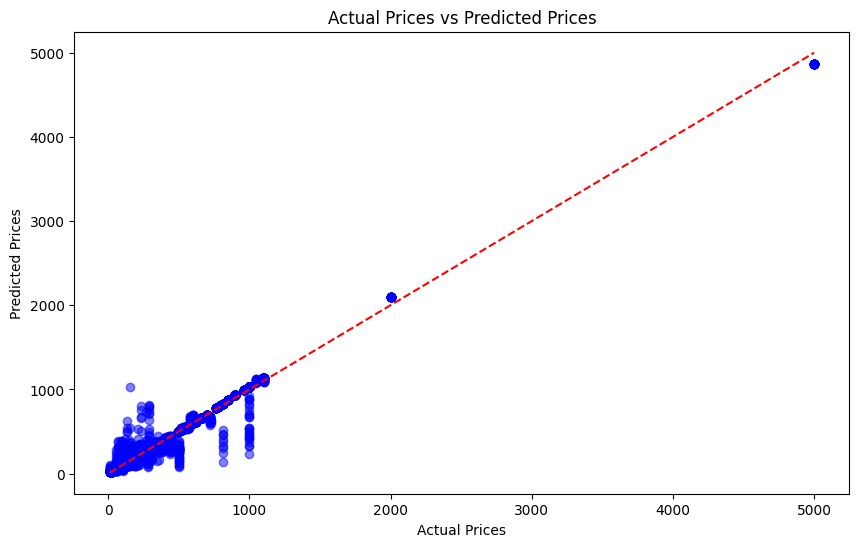

In [ ]:
# Plotting actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_test_pred_unscaled, color='blue', alpha=0.5)
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Prices vs Predicted Prices')

plt.show()

In [ ]:
# Unscaling the datasets
train_data_lstm_unscaled = train_data_lstm.copy()
train_data_lstm_unscaled['price'] = scaler.inverse_transform(train_data_lstm[['price']])

val_data_lstm_unscaled = val_data_lstm.copy()
val_data_lstm_unscaled['price'] = scaler.inverse_transform(val_data_lstm[['price']])

test_data_lstm_unscaled = test_data_lstm.copy()
test_data_lstm_unscaled['price'] = scaler.inverse_transform(test_data_lstm[['price']])


